In [ ]:
%tensorflow_version 2.x # selecting tensorflow version

!sudo pip install --upgrade pip;
!sudo pip install --upgrade tensorflow;

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

---

## Στοιχεία Ομάδας

Αριθμός Ομάδας F05

  > Καρυπιάδης Ευστράτιος: 03114911
  
  > Σταματελόπουλος Νικόλαος: 03116138

---

## Σύνολο Δεδομένων CIFAR-100

Το σύνολο δεδομένων στο οποίο θα εργαστούμε είναι το [CIFAR-100](https://bit.ly/38CUquZ), το οποίο αποτελείται απο 60.000 έγχρωμες εικόνες διαστάσεων 32x32. Κάθε μία από αυτές ανήκει σε μία γενική(*fine*) και μία ειδική(*coarse*) κατηγορία του συνόλου, πλήθους 100 και 20 αντίστοιχα. Προς ταξινόμηση των δειγμάτων μας θα εκμεταλευτούμε μονάχα τις *fine* κατηγορίες των εικόνων που έχουμε στη διάθεσή μας.

	

### Εισαγωγή συνόλου δεδομένων

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import datasets, layers, models, utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# loading the entire dataset
(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

Για τους σκοπούς της άσκησης **δε** θα εκμεταλλευτούμε ολόκληρο το σύνολο δεδομένων, αλλά θα δουλέψουμε σε ένα υποσύνολο αυτού σύμφώνα με τον αύξοντα αριθμό της ομάδας μας, `team_seed`. Στη συνέχεια υλοποιούμε μία σειρά βοηθητικών συναρτήσεων που θα μας βοηθήσουν σε αυτόν το διαχωρισμό:

In [ ]:
def select_from_list(from_list, index_list):
  """ Return from_list elemenents according to index contained in index_list. """
  filtered_list= [from_list[i] for i in index_list]
  return(filtered_list)

def get_ds_index(unfiliterd_list, target_list):
  """ Append in filtered_list the index of each element in unfiltered_list if it exists in target_list. """
  index = 0
  filtered_list=[]
  for i_ in unfiliterd_list:
    if i_[0] in target_list:
      filtered_list.append(index)
    index += 1
  return(filtered_list)

def select_classes_number(classes_number=20):
  """ Select unique subset of CIFAR-100 with classes_number of classes. """
  if classes_number == 20:
    return "https://bit.ly/3b3Cewb"
  elif classes_number == 40:
    return "https://bit.ly/3aPo819"
  elif classes_number == 60:
    return "https://bit.ly/2Wbo47K"
  elif classes_number == 80:
    return "https://bit.ly/38NDW3d"
  else:
    return -1

### Διαχωρισμός δεδομένων εκπαίδευσης - ελέγχου

Στο επόμενο κελί επιλέγουμε το πλήθος των κατηγοριών με το οποίο επιθυμούμε να δουλέψουμε:

In [ ]:
cifar100_classes_url = select_classes_number(classes_number=80) # default: 20 classes

Δημιουργούμε το μοναδικό dataset της ομάδας μας:

In [ ]:
team_seed = 5 # team_seed number

team_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None) # fetch class indexes
CIFAR100_LABELS_LIST = pd.read_csv("https://bit.ly/3cRO3qZ", sep=',', header=None).astype(str).values.tolist()[0] # fetch class names

our_index = team_classes.iloc[team_seed, :].values.tolist() # select team class indices
our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index) # select team class names

train_index = get_ds_index(y_train_all, our_index)
test_index = get_ds_index(y_test_all, our_index)

# Train data and labels
x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
y_train_ds = np.asarray(select_from_list(y_train_all, train_index))

# Test data and labels
x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
y_test_ds = np.asarray(select_from_list(y_test_all, test_index))

Μετά την παραπάνω διαδικασία εμφανίζουμε τα ονόματα των κατηγοριών που αντιστοιχούν στην ομάδα μας:

In [ ]:
print(our_classes)

[' aquarium_fish', ' baby', ' bear', ' beaver', ' bee', ' bicycle', ' bottle', ' bowl', ' boy', ' bus', ' camel', ' can', ' castle', ' caterpillar', ' cattle', ' chair', ' clock', ' cloud', ' cockroach', ' crab', ' crocodile', ' cup', ' dinosaur', ' dolphin', ' elephant', ' flatfish', ' forest', ' fox', ' girl', ' hamster', ' kangaroo', ' keyboard', ' lamp', ' lawn_mower', ' leopard', ' lion', ' lizard', ' lobster', ' man', ' maple_tree', ' motorcycle', ' mountain', ' mouse', ' mushroom', ' orange', ' orchid', ' otter', ' palm_tree', ' pickup_truck', ' pine_tree', ' porcupine', ' possum', ' rabbit', ' raccoon', ' ray', ' road', ' rocket', ' rose', ' sea', ' seal', ' shark', ' skunk', ' skyscraper', ' snail', ' snake', ' squirrel', ' streetcar', ' sunflower', ' table', ' tank', ' television', ' tractor', ' train', ' trout', ' tulip', ' turtle', ' wardrobe', ' whale', ' wolf', ' worm']


### Επισκόπηση δεδομένων και κανονικοποίηση

Τέλος, για καλύτερη εποπτεία του συνόλου δεδομένων μας θα εξάγουμε ορισμένες χρήσιμες πληροφορίες για αυτό, ενώ παράλληλα θα κανονικοποιήσουμε τις τιμές αναπαράστασης των εικόνων:

In [ ]:
data_size, img_rows, img_cols, img_channels = x_train_ds.shape # get train dataset dimensions

# Set validation set percentage
validation_percentage = 0.15
val_size = round(validation_percentage * data_size)

# Reserve val_size samples for validation and normalize all values
x_val = x_train_ds[-val_size:]/255
y_val = y_train_ds[-val_size:]
x_train = x_train_ds[:-val_size]/255
y_train = y_train_ds[:-val_size]
x_test = x_test_ds/255
y_test = y_test_ds

# Summarize loaded dataset
print('Train:       X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Validation:  X=%s, y=%s' % (x_val.shape, y_val.shape))
print('Test:        X=%s, y=%s' % (x_test.shape, y_test.shape))

Train:       X=(34000, 32, 32, 3), y=(34000, 1)
Validation:  X=(6000, 32, 32, 3), y=(6000, 1)
Test:        X=(8000, 32, 32, 3), y=(8000, 1)


---

## Συναρτήσεις Προετοιμασίας Δεδομένων και Οπτικοποίησης Απόδοσης

Στη συνέχεια θα υλοποιήσουμε απαραίτητες συναρτήσεις προετοιμασίας των δεδομένων για εκπαίδευση, καθώς και οπτικοποίσης της τελικής απόδοσης των μοντέλων που πρόκειται να δοκιμάσουμε.

### Συναρτήσεις εκπαίδευσης

Αρχικά θα υλοποιήσουμε την `_input_fn`, η οποία αποτελεί ένα *pipeline* που θα προετοιμάσει τα δεδομένα μας για την εκπαίδευση. Πιο συγκεκριμένα, χρησιμοποιούμε τις μεθόδους `shuffle`, `repeat` και `batch` της [tf.data.Dataset](https://bit.ly/2vk7EPr), ώστε να δημιουργήσουμε υποσύνολα 64 δειγμάτων, τα οποία ελήφθησαν τυχαίως από το ολικό μας σύνολο. Παρατηρούμε ότι η μέθοδος `repeat` είναι απαραίτητη για να αντιμετωπίσουμε τυχόν σφάλμα που θα προκύψει, εάν η μέθοδος `batch` επιχειρήσει να δημιουργήσει εκ νέου υποσύνολο, αφού έχει ομαδοποιήσει όλα τα διαθέσιμα δείγματα του συνόλου. 

Σημειώνουμε ότι η συνάρτηση επιστρέφει υποσύνολα δεδομένων `PrefetchDataset Objects`, μορφή η οποία επιταχύνει τη διαδικασία εκπαίδευσης, καθώς επιτρέπει το διάβασμα του επόμενου batch δεδομένων, ενώ παράλληλα εκπαιδεύεται το παρόν.

In [ ]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE

def _input_fn(x, y, BATCH_SIZE):
  """ Returns shuffled and batched tensors in the form of PrefetchDataset objects. """
  ds = tf.data.Dataset.from_tensor_slices((x, y))
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat() # repeat indefinately
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

# PrefetchDataset objects
train_ds =_input_fn(x_train, y_train, BATCH_SIZE)
validation_ds =_input_fn(x_val, y_val, BATCH_SIZE)
test_ds =_input_fn(x_test, y_test, BATCH_SIZE)

Στη συνέχεια υλοποιούμε τη συνάρτηση `train_model`. Σημειώνουμε ότι με την παράμετρο `steps_per_epoch` μπορούμε να επιλέξουμε το πλήθος των *batches* στο οποίο επιθυμούμε να εκπαιδευτεί το μοντέλο μας πριν περάσει στην επόμενη εποχή.

In [ ]:
def train_model(model, epochs):
  """ Training function. """
  history = model.fit(train_ds, epochs=epochs, steps_per_epoch=x_train.shape[0]//BATCH_SIZE, validation_data=validation_ds, validation_steps=x_val.shape[0]//BATCH_SIZE)
  return(history)

### Γραφικές παραστάσεις εκπαίδευσης και απόδοση στο σύνολο ελέγχου

Τέλος, υλοποιούμε συναρτήσεις οπτικοποίησης της απόδοσης της εκπαίδευσης προς εξαγωγή χρήσιμων πληροφοριών και μελέτη των αποτελεσμάτων που θα προκύψουν από τη δοκιμή των μοντέλων μας.

In [22]:
def summarize_diagnostics(history):
	""" Plot diagnostic learning curves. """
	plt.figure(figsize=(10, 6))
	plt.title('Classification Accuracy')
	if "accuracy" in history.history:
		plt.plot(history.history['accuracy'], color='blue', label='Train')
		plt.plot(history.history['val_accuracy'], color='orange', label='Validation')
	else:
		plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='Train')
		plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='Validation')
	plt.legend(loc='lower right')
	plt.grid()
	plt.show()
 
def model_evaluation(model, evaluation_steps):
	""" Print test set and evaluation metrics. """
	print('\nTest set evaluation metrics')
	loss0, accuracy0 = model.evaluate(test_ds, steps=x_test.shape[0]//BATCH_SIZE)
	print("loss: {:.2f}".format(loss0))
	print("accuracy: {:.2f}".format(accuracy0))

def model_report(model, history, evaluation_steps=10):
	summarize_diagnostics(history)
	model_evaluation(model, evaluation_steps)
 
def summarize_all_diagnostics(m1, m2, m3, m4, m5):
	plt.figure(figsize=(10, 6))
	plt.title('Classification Accuracy')
	plt.plot(m1['sparse_categorical_accuracy'], color='red', linestyle='-', label='Softmax')
	plt.plot(m1['val_sparse_categorical_accuracy'], color='red', linestyle='--')
	plt.plot(m2['sparse_categorical_accuracy'], color='blue', linestyle='-', label='MLP')
	plt.plot(m2['val_sparse_categorical_accuracy'], color='blue', linestyle='--')
	plt.plot(m3['sparse_categorical_accuracy'], color='green', linestyle='-', label='LeNet')
	plt.plot(m3['val_sparse_categorical_accuracy'], color='green', linestyle='--')
	plt.plot(m4['sparse_categorical_accuracy'], color='orange', linestyle='-', label='CNN1')
	plt.plot(m4['val_sparse_categorical_accuracy'], color='orange', linestyle='--')
	plt.plot(m5['sparse_categorical_accuracy'], color='magenta', linestyle='-', label='CNN2')
	plt.plot(m5['val_sparse_categorical_accuracy'], color='magenta', linestyle='--')
	plt.legend(loc='lower right')
	plt.grid()
	plt.show()

def summarize_before_after(m1, m2, m3, m4, m5, m6, m7, m8, m9, m10):
	plt.figure(figsize=(10, 6))
	plt.title('Classification Accuracy')
	plt.plot(m1['val_sparse_categorical_accuracy'], color='red', linestyle='-', label='Softmax')
	plt.plot(m2['val_sparse_categorical_accuracy'], color='red', linestyle='-.')
	plt.plot(m3['val_sparse_categorical_accuracy'], color='blue', linestyle='-', label='MLP')
	plt.plot(m4['val_sparse_categorical_accuracy'], color='blue', linestyle='-.')
	plt.plot(m5['val_sparse_categorical_accuracy'], color='green', linestyle='-', label='LeNet')
	plt.plot(m6['val_sparse_categorical_accuracy'], color='green', linestyle='-.')
	plt.plot(m7['val_sparse_categorical_accuracy'], color='orange', linestyle='-', label='CNN1')
	plt.plot(m8['val_sparse_categorical_accuracy'], color='orange', linestyle='-.')
	plt.plot(m9['val_sparse_categorical_accuracy'], color='magenta', linestyle='-', label='CNN2')
	plt.plot(m10['val_sparse_categorical_accuracy'], color='magenta', linestyle='-.')
	plt.legend(loc='lower right')
	plt.grid()
	plt.show()

---

## Ερώτημα 1: Μοντέλα Δικτύων

In [ ]:
import json # for saving training history

Στη συνέχεια καλούμαστε να υλοποιήσουμε 5 διαφορετικές αρχιτεκτονικές συνελικτικών δικτύων. Για κάθε μία από αυτές θα πρέπει να επιλέξουμε δύο βέλτιστους συνδυασμούς optimizer, loss function, metrics και epoch.

- Σχετικά με τους [optimizers](https://keras.io/api/optimizers/) δοκιμάσαμε σε όλες τις αρχιτεκτονικές τους [Adam](https://keras.io/api/optimizers/adam/), [Nadam](https://keras.io/api/optimizers/Nadam/), [Adamax](https://keras.io/api/optimizers/adamax/), [Adagrad](https://keras.io/api/optimizers/adagrad/), [Adadelta](https://keras.io/api/optimizers/adadelta/), [RMSProp](https://keras.io/api/optimizers/rmsprop/) και [Stochastic Gradient Descent](https://keras.io/api/optimizers/sgd/). Επιλέξαμε δύο από αυτούς σε κάθε δίκτυο, ανάλογα με την απόδοσή τους. Αξίζει να σημειώσουμε ότι σε κάθε optimizer, πειραματιστήκαμε και με το ρυθμό μάθησης, για να αποφανθούμε για την επίδοσή του.

- Μελετώντας το API του Keras, παρατηρούμε ότι η μοναδική [loss function](https://keras.io/api/losses/) που εξυπηρετεί την επίλυση του προβλήματός μας είναι η [Categorical Cross Entropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class). Καταλήγουμε σε αυτήν την επιλογή, αγνοώντας αφενός τα regression losses, καθώς δεν εφάπτονται της ταξινόμησης εικόνων που επιχειρούμε και αφετέρου τις συναρτήσεις Kullback-Leibler Divergence και Hinge. Σχετικά με τις δύο τελευταίες, παρατηρούμε ότι μέσα από πειραματισμούς μας δε φαίνεται να συγκλίνουν σε ελάχιστη τιμή, ενώ παράλληλα δίνουν χαμηλές τιμές απόδοσης στα metrics που δοκιμάσαμε. Επίσης σημειώνουμε ότι οι συγκεκριμένες συναρτήσεις συνηθίζεται να χρησιμοποιούνται σε διαφορετικού τύπου εφαρμογές, όπως για παράδειγμα στους Autoencoders.

- Βασική μας [metric](https://keras.io/api/metrics/) συνάρτηση είναι η [ακρίβεια ταξινόμησης](https://keras.io/api/metrics/accuracy_metrics/#accuracy-class), πάνω στην οποία θα στηριχτούμε προκειμένου να αποφανθούμε για την απόδοση των δικτύων μας. Σημειώνουμε, ωστόσο, ότι θα κάνουμε χρήση της [sparse categorical accuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/SparseCategoricalAccuracy) καθώς οι ετικέτες των δεδομένων μας είναι κωδικοποιημένες σε sparse μορφή. Προφανώς οι δύο μετρικές είναι ισοδύναμες.

- Τέλος, σημειώνουμε ότι κατά τη διαδικασία δοκιμών των παραπάνω παραμέτρων, εκπαιδεύσαμε πειραματικά κάθε δίκτυο για διάρκεια 10 εποχών. Σύμφωνα με τα αποτελέσματα που συλλέξαμε, επιλέξαμε για την εκάστοτε αρχιτεκτονική τους 2 καλύτερους συνδυασμούς, τους οποίους χρησιμοποιήσαμε για την ολοκληρωμένη εκπαίδευση, διάρκειας τουλάχιστον 50 εποχών, των τελικών 10 δικτύων μας.

Σημειώνουμε ότι η αρχιτεκτονική των παρακάτω μοντέλων μας ολοκληρώνεται με ένα fully connected επίπεδο με πλήθος νευρώνων ίσο με το πλήθος των κλάσεων που δουλέυουμε. Δεδομένου, ωστόσο, ότι δεν δουλέυουμε πάνω στις 100 κλάσεις του CIFAR, αλλά στις 80, οι ετικέτες μας είναι πολύ πιθανό να περιέχουν κλάσεις με αύξοντα αριθμό μεγαλύτερο του 80, γεγονός το οποίο προκαλεί ανεπιθύμητα αποτελέσματα τόσο στις μετρικές μας, οι οποίες είναι αδύνατο να υπολογιστούν, όσο και στην ελαχιστοποίηση του σφάλματος που έχουμε επιλέξει. Για αυτούς τους λόγους, τοποθετούμε ένα fully connected επίπεδο με 100 νευρώνες.

### Softmax (Adam & Adagrad)

Το πρώτο μοντέλο που θα εκπαιδεύσουμε εκμεταλλεύεται optimizer `Adam` με `lr=0.0001`. Παρατηρώντας το διάγραμμα απόδοσης που ακολουθεί, οι 50 `epochs` είναι αρκετές για την εκπαίδευση του μοντέλου, δεδομένου ότι δεν παρουσιάζεται τάση ανόδου για την απόδοση του δικτύου στα δεδομένα επαλήθευσης.

In [ ]:
def init_softmax_adam(summary):
  
  model = models.Sequential()
  
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(200))
  model.add(layers.Dense(100, activation='softmax'))

  model.compile(optimizer=tf.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
SOFTMAX_MODEL_ADAM = init_softmax_adam(summary=True)

# Train for 50 epochs
SOFTMAX_MODEL_ADAM_history = train_model(SOFTMAX_MODEL_ADAM, 50)

# Dump training history
history_dict = SOFTMAX_MODEL_ADAM_history.history
json.dump(history_dict, open('SOFTMAX_MODEL_ADAM.json', 'w'))

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_15 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 200)               614600    
_________________________________________________________________
dense_31 (Dense)             (None, 100)               20100     
Total params: 634,700
Trainable params: 634,700
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
531/531 [==============================] - 3s 6ms/step - loss: 4.0910 - sparse_categorical_accuracy: 0.0747 - val_loss: 3.8616 - val_sparse_categorical_accuracy: 0.1168
Epoch 2/50
531/531 [==============================] - 3s 6ms/step - loss: 3.7633 - sparse_categorical_accuracy: 0.1295 - val_loss: 3.7286 - val_sparse_categorical_accuracy: 0.1410
Epoch 3/50
531/53

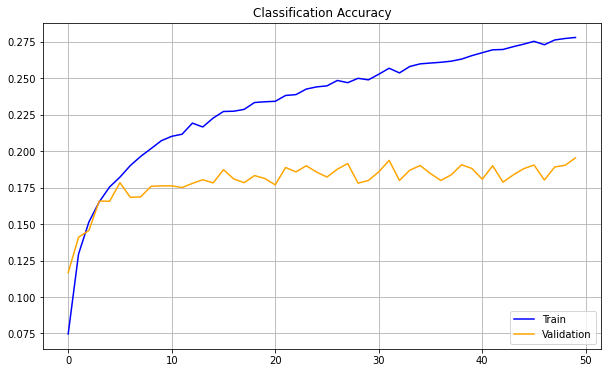


Test set evaluation metrics
125/125 [==============================] - 0s 4ms/step - loss: 3.5022 - sparse_categorical_accuracy: 0.2009
loss: 3.50
accuracy: 0.20


In [ ]:
model_report(SOFTMAX_MODEL_ADAM, SOFTMAX_MODEL_ADAM_history)

Το δεύτερο μοντέλο μας έχει `Adagrad` optimizer με `lr=0.01`. Διατηρούμε και εδώ τις 50 `epochs` εκπαίδευσης.

In [ ]:
def init_softmax_adagrad(summary):
  
  model = models.Sequential()
  
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(200))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adagrad(lr=0.01), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
SOFTMAX_MODEL_ADAGRAD = init_softmax_adagrad(summary=True)

# Train for 50 epochs
SOFTMAX_MODEL_ADAGRAD_history = train_model(SOFTMAX_MODEL_ADAGRAD, 50)

# Dump training history
history_dict = SOFTMAX_MODEL_ADAGRAD_history.history
json.dump(history_dict, open('SOFTMAX_MODEL_ADAGRAD.json', 'w'))

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_16 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 200)               614600    
_________________________________________________________________
dense_33 (Dense)             (None, 100)               20100     
Total params: 634,700
Trainable params: 634,700
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
531/531 [==============================] - 3s 6ms/step - loss: 4.0693 - sparse_categorical_accuracy: 0.0781 - val_loss: 3.8237 - val_sparse_categorical_accuracy: 0.1146
Epoch 2/50
531/531 [==============================] - 3s 6ms/step - loss: 3.7224 - sparse_categorical_accuracy: 0.1329 - val_loss: 3.8397 - val_sparse_categorical_accuracy: 0.0964
Epoch 3/50
531/53

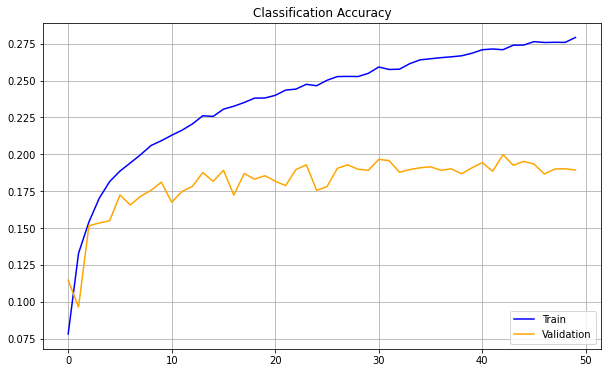


Test set evaluation metrics
125/125 [==============================] - 0s 4ms/step - loss: 3.4850 - sparse_categorical_accuracy: 0.1981
loss: 3.48
accuracy: 0.20


In [ ]:
model_report(SOFTMAX_MODEL_ADAGRAD, SOFTMAX_MODEL_ADAGRAD_history)

Παρατηρώντας τα διαγράμματα για τα δύο μοντέλα μας, μπορούμε να αποφανθούμε για την ακρίβεια στο validation set μας, η οποία ισούται με περίπου 19% και για τα δύο δίκτυα. Αξιολογώντας την ακρίβεια των δύο παραπάνω μοντέλων στο test set μας, καταλήγουμε σε 20% και για τα δύο. Θα επιλέξουμε, λοιπόν, εκείνο το μοντέλο που χαρακτιρίζεται από το ελάχιστο σφάλμα. Ο καλύτερος συνδυασμός που επιλέγουμε είναι **Adagrad optimizer, sparse categorical cross entropy loss, sparse categorical accuracy και 50 εποχές εκπαίδευσης**.

### MLP (Nadam & Adagrad)

Το πρώτο μοντέλο που θα εκπαιδεύσουμε εκμεταλλεύεται optimizer `Nadam` με `lr=0.0001`. Εδώ επιλέγουμε 75 `epochs` εκπαίδευσης παρατηρώντας την ανοδική τάσης της ακρίβειας του δικτύου στα δεδομένα επαλήθευσης που κυριαρχούσε στις 50 εποχές.

In [ ]:
def init_mlp_nadam(summary):
  
  model = models.Sequential()
 
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(200))
  model.add(layers.Dense(100, activation='softmax'))

  model.compile(optimizer=tf.optimizers.Nadam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
MLP_MODEL_NADAM = init_mlp_nadam(summary=True)

# Train for 75 epochs
MLP_MODEL_NADAM_history = train_model(MLP_MODEL_NADAM, 75)

# Dump training history
history_dict = MLP_MODEL_NADAM_history.history
json.dump(history_dict, open('MLP_MODEL_NADAM.json', 'w'))

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_17 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)               1573376   
_________________________________________________________________
dense_35 (Dense)             (None, 200)               102600    
_________________________________________________________________
dense_36 (Dense)             (None, 100)               20100     
Total params: 1,696,076
Trainable params: 1,696,076
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
531/531 [==============================] - 5s 10ms/step - loss: 4.0110 - sparse_categorical_accuracy: 0.0848 - val_loss: 3.7955 - val_sparse_categorical_accuracy: 0.1132
Epoch 2/75
531/531 [==============================] - 5s 9ms

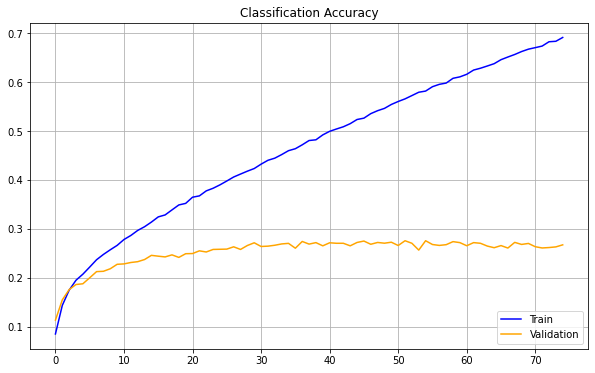


Test set evaluation metrics
125/125 [==============================] - 1s 4ms/step - loss: 3.7311 - sparse_categorical_accuracy: 0.2630
loss: 3.73
accuracy: 0.26


In [ ]:
model_report(MLP_MODEL_NADAM, MLP_MODEL_NADAM_history)

Το δεύτερο μοντέλο μας έχει `Adagrad` optimizer με `lr=0.01`. Διατηρούμε τις 75 `epochs` εκπαίδευσης.

In [ ]:
def init_mlp_adagrad(summary):
  
  model = models.Sequential()
 
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(200))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adagrad(lr=0.01), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
MLP_MODEL_ADAGRAD = init_mlp_adagrad(summary=True)

# Train for 100 epochs
MLP_MODEL_ADAGRAD_history = train_model(MLP_MODEL_ADAGRAD, 75)

# Dump training history
history_dict = MLP_MODEL_ADAGRAD_history.history
json.dump(history_dict, open('MLP_MODEL_ADAGRAD.json', 'w'))

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_18 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 512)               1573376   
_________________________________________________________________
dense_38 (Dense)             (None, 200)               102600    
_________________________________________________________________
dense_39 (Dense)             (None, 100)               20100     
Total params: 1,696,076
Trainable params: 1,696,076
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
531/531 [==============================] - 3s 6ms/step - loss: 4.0057 - sparse_categorical_accuracy: 0.0787 - val_loss: 3.7421 - val_sparse_categorical_accuracy: 0.1253
Epoch 2/75
531/531 [==============================] - 3s 6ms/

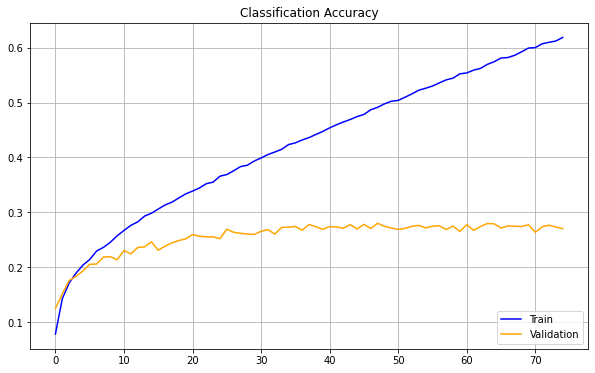


Test set evaluation metrics
125/125 [==============================] - 0s 4ms/step - loss: 3.2975 - sparse_categorical_accuracy: 0.2747
loss: 3.30
accuracy: 0.27


In [ ]:
model_report(MLP_MODEL_ADAGRAD, MLP_MODEL_ADAGRAD_history)

Παρατηρώντας τα διαγράμματα για τα δύο μοντέλα μας, μπορούμε να αποφανθούμε για την ακρίβεια στο validation set μας, η οποία ισούται με 24% και 27% στα αντίστοιχα δίκτυα. Αξιολογώντας την ακρίβεια των δύο παραπάνω μοντέλων στο test set μας, καταλήγουμε σε 26% και 27%, αντίστοιχα. Ο καλύτερος συνδυασμός που επιλέγουμε είναι **Adagrad optimizer, sparse categorical cross entropy loss, sparse categorical accuracy και 75 εποχές εκπαίδευσης**.

### LeNet (Adam & Adamax)

Το πρώτο μοντέλο που θα εκπαιδεύσουμε εκμεταλλεύεται optimizer `Adam` με `lr=0.0001`. Ακολουθώντας το ίδιο σκεπτικό με παραπάνω, επιλέγουμε 100 `epochs` εκπαίδευσης.

In [ ]:
def init_lenet_adam(summary):
  
  model = models.Sequential()
 
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(200))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
LENET_MODEL_ADAM = init_lenet_adam(summary=True)

# Train for 100 epochs
LENET_MODEL_ADAM_history = train_model(LENET_MODEL_ADAM, 100)

# Dump training history
history_dict = LENET_MODEL_ADAM_history.history
json.dump(history_dict, open('LENET_MODEL_ADAM.json', 'w'))

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_41 (Dense)             (None, 200)             

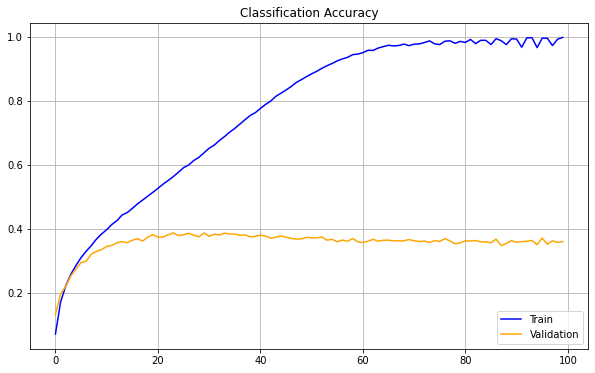


Test set evaluation metrics
125/125 [==============================] - 1s 5ms/step - loss: 6.9892 - sparse_categorical_accuracy: 0.3643
loss: 6.99
accuracy: 0.36


In [ ]:
model_report(LENET_MODEL_ADAM, LENET_MODEL_ADAM_history)

Το δεύτερο μοντέλο έχει `Adamax` optimizer με `lr=0.01`. Διατηρούμε τις 100 `epochs` εκπαίδευσης.

In [ ]:
def init_lenet_adamax(summary):
  
  model = models.Sequential()
 
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(200))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
LENET_MODEL_ADAMAX = init_lenet_adamax(summary=True)

# Train for 100 epochs
LENET_MODEL_ADAMAX_history = train_model(LENET_MODEL_ADAMAX, 100)

# Dump training history
history_dict = LENET_MODEL_ADAMAX_history.history
json.dump(history_dict, open('LENET_MODEL_ADAMAX.json', 'w'))

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_44 (Dense)             (None, 200)             

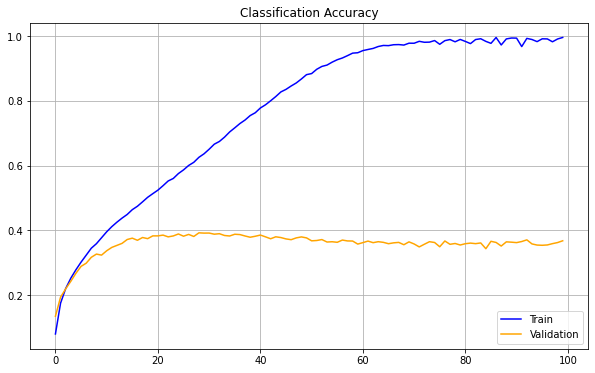


Test set evaluation metrics
125/125 [==============================] - 1s 5ms/step - loss: 6.8345 - sparse_categorical_accuracy: 0.3767
loss: 6.83
accuracy: 0.38


In [ ]:
model_report(LENET_MODEL_ADAMAX, LENET_MODEL_ADAMAX_history)

Παρατηρώντας τα διαγράμματα για τα δύο μοντέλα μας, μπορούμε να αποφανθούμε για την ακρίβεια στο validation set μας, η οποία ισούται με περίπου 36% και για τα δύο δίκτυα. Αξιολογώντας την ακρίβεια των δύο παραπάνω μοντέλων στο test set μας, καταλήγουμε σε 36 και 38%, αντίστοιχα. Ο καλύτερος συνδυασμός που επιλέγουμε είναι **Adamax optimizer, sparse categorical cross entropy loss, sparse categorical accuracy και 75 εποχές εκπαίδευσης**. Παρατηρούμε, δηλαδή ότι οι 100 εποχές εκαπίδευσης δεν βοήθησαν σε περαιτέρω βελτίωση της απόδοσης των δικτύων μας και μονάχα αύξησαν το χρόνο εκπαίδευσης.

### CNN1 (Adam & SGD)

Το πρώτο μοντέλο που θα εκπαιδεύσουμε εκμεταλλεύεται optimizer `Adam` με `lr=0.0001`. Ακολουθώντας το ίδιο σκεπτικό με παραπάνω, επιλέγουμε 100 `epochs` εκπαίδευσης.

In [ ]:
def init_cnn1_adam(summary):
  
  model = models.Sequential()
 
  model.add(layers.Conv2D(16, (5, 5), activation='relu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))

  model.add(layers.Flatten())
  model.add(layers.Dense(200))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
CNN1_MODEL_ADAM = init_cnn1_adam(summary=True)

# Train for 100 epochs
CNN1_MODEL_ADAM_history = train_model(CNN1_MODEL_ADAM, 100)

# Dump training history
history_dict = CNN1_MODEL_ADAM_history.history
json.dump(history_dict, open('CNN1_MODEL_ADAM.json', 'w'))

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 16)        1216      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 16)        2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 32)          4640      
_________________________________________________________________
flatten_21 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_46 (Dense)             (None, 200)             

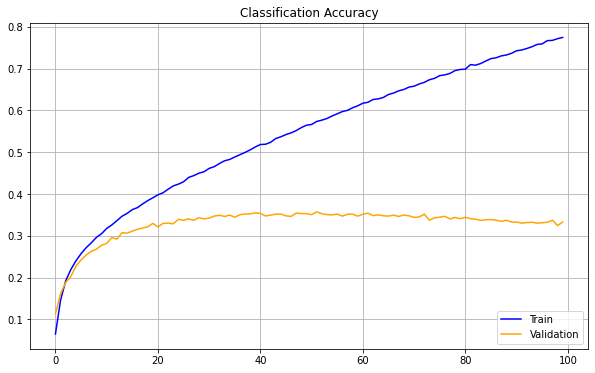


Test set evaluation metrics
125/125 [==============================] - 1s 5ms/step - loss: 3.9085 - sparse_categorical_accuracy: 0.3286
loss: 3.91
accuracy: 0.33


In [ ]:
model_report(CNN1_MODEL_ADAM, CNN1_MODEL_ADAM_history)

Το δεύτερο μοντέλο έχει `SGD` optimizer με `lr=0.01`. Διατηρούμε τις 100 `epochs` εκπαίδευσης.

In [ ]:
def init_cnn1_sgd(summary):
  
  model = models.Sequential()
 
  model.add(layers.Conv2D(16, (5, 5), activation='relu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))

  model.add(layers.Flatten())
  model.add(layers.Dense(200))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.SGD(lr=0.01), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
CNN1_MODEL_SGD = init_cnn1_sgd(summary=True)

# Train for 100 epochs
CNN1_MODEL_SGD_history = train_model(CNN1_MODEL_SGD, 100)

# Dump training history
history_dict = CNN1_MODEL_SGD_history.history
json.dump(history_dict, open('CNN1_MODEL_SGD.json', 'w'))

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 16)        1216      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 16)        2320      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 32)          4640      
_________________________________________________________________
flatten_22 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 200)             

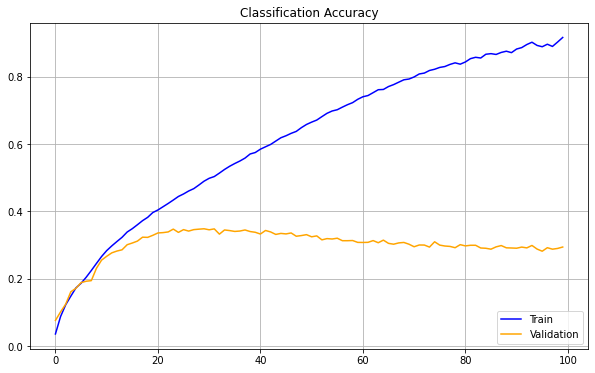


Test set evaluation metrics
125/125 [==============================] - 1s 5ms/step - loss: 8.8372 - sparse_categorical_accuracy: 0.3013
loss: 8.84
accuracy: 0.30


In [ ]:
model_report(CNN1_MODEL_SGD, CNN1_MODEL_SGD_history)

Παρατηρώντας τα διαγράμματα για τα δύο μοντέλα μας, μπορούμε να αποφανθούμε για την ακρίβεια στο validation set μας, η οποία είναι περίπου ίση με 33% και 30%, αντίστοιχα. Αξιολογώντας την ακρίβεια των δύο παραπάνω μοντέλων στο test set μας, καταλήγουμε επίσης σε 33% και 30%, αντίστοιχα. Ο καλύτερος συνδυασμός που επιλέγουμε είναι **Adaμ optimizer, sparse categorical cross entropy loss, sparse categorical accuracy και 75 εποχές εκπαίδευσης.** Παρατηρούμε, δηλαδή και εδώ ότι οι 100 εποχές εκπαίδευσης, δεν συμβάλλουν στη βελτίωση των μοντέλων μας, οπότε επιλέγουμε να τις μειώσουμε, για να εξοικονομήσουμε χρόνο εκπαίδευσης.

### CNN2 (Adam & RMSprop)

Η αρχιτεκτονική του δικτύου μας είναι επηρεασμένη από εκείνη του VGG16. Το πρώτο μοντέλο που θα εκπαιδεύσουμε εκμεταλλεύεται optimizer `Adam` με `lr=0.0001`. Παρατηρούμε ότι οι 50 `epochs` εκπαίδευσης είναι αρκετές για το μοντέλο μας.

In [ ]:
def init_CNN2_adam(summary):
  
  model = models.Sequential()
  
  model.add(layers.Conv2D(128, (3, 3), activation='elu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(128, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(256, (3, 3), activation='elu', padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(512, (3, 3), activation='elu', padding='same'))
  model.add(layers.Conv2D(512, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
 
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='elu'))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  
  if summary: 
    model.summary()
  return model

In [ ]:
# Initialize model
CNN2_MODEL_ADAM = init_CNN2_adam(summary=True)

# Train for 50 epochs
CNN2_MODEL_ADAM_history = train_model(CNN2_MODEL_ADAM, 50)

# Dump training history
history_dict = CNN2_MODEL_ADAM_history.history
json.dump(history_dict, open('CNN2_MODEL_ADAM.json', 'w'))

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 30, 30, 128)       147584    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 15, 15, 256)       295168    
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 13, 13, 256)       590080    
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 6, 6, 512)       

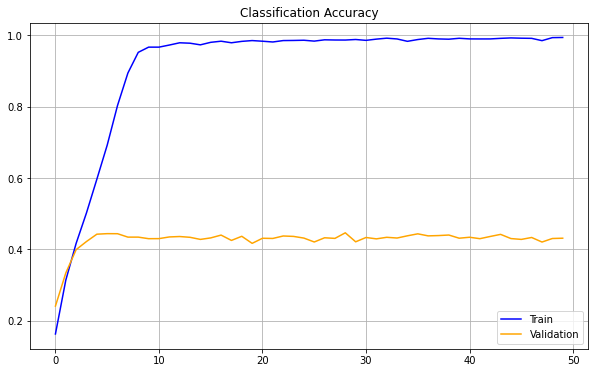


Test set evaluation metrics
125/125 [==============================] - 3s 23ms/step - loss: 5.7723 - sparse_categorical_accuracy: 0.4459
loss: 5.77
accuracy: 0.45


In [ ]:
model_report(CNN2_MODEL_ADAM, CNN2_MODEL_ADAM_history)

Το δεύτερο μοντέλο μας έχει `RMSprop` optimizer με `lr=0.01`. Διατηρούμε σταθερή τη διάρκεια εκπαίδευσης στις 50 `epochs`.

In [ ]:
def init_CNN2_rmsprop(summary):
  
  model = models.Sequential()
  
  model.add(layers.Conv2D(128, (3, 3), activation='elu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(128, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(256, (3, 3), activation='elu', padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(512, (3, 3), activation='elu', padding='same'))
  model.add(layers.Conv2D(512, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
 
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='elu'))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.RMSprop(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  
  if summary: 
    model.summary()
  return model

In [ ]:
# Initialize model
CNN2_MODEL_RMSPROP = init_CNN2_rmsprop(summary=True)

# Train for 50 epochs
CNN2_MODEL_RMSPROP_history = train_model(CNN2_MODEL_RMSPROP, 50)

# Dump training history
history_dict = CNN2_MODEL_RMSPROP_history.history
json.dump(history_dict, open('CNN2_MODEL_RMSPROP.json', 'w'))

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 30, 30, 128)       147584    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 15, 15, 256)       295168    
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 13, 13, 256)       590080    
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 6, 6, 512)       

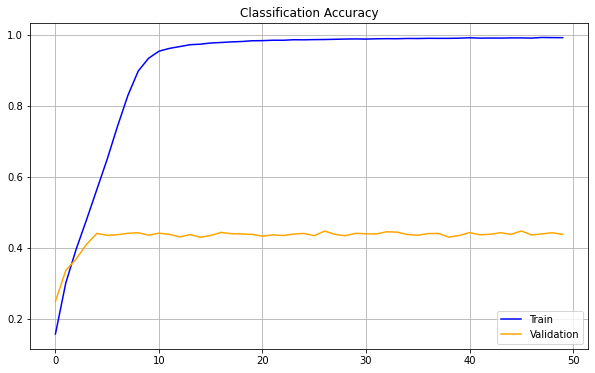


Test set evaluation metrics
125/125 [==============================] - 3s 23ms/step - loss: 7.2933 - sparse_categorical_accuracy: 0.4495
loss: 7.29
accuracy: 0.45


In [ ]:
model_report(CNN2_MODEL_RMSPROP, CNN2_MODEL_RMSPROP_history)

Παρατηρώντας τα διαγράμματα για τα δύο μοντέλα μας, μπορούμε να αποφανθούμε για την ακρίβεια στο validation set μας, η οποία είναι περίπου ίση με 43% και για τα δύο δίκτυα. Αξιολογώντας την ακρίβεια των δύο παραπάνω μοντέλων στο test set μας, καταλήγουμε επίσης σε 45% και για τα δύο μοντέλα. Παρατηρούμε, ωστόσο ότι το πρώτο μας δίκτυο χαρακτηρίζεται από αισθητά χαμηλότερο σφάλμα, γεγονός στο οποίο θα στηρίξουμε την επιλογή του καλύτερου μοντέλου μας. Ο καλύτερος συνδυασμός που επιλέγουμε είναι **Adam optimizer, sparse categorical cross entropy loss, sparse categorical accuracy και 50 εποχές εκπαίδευσης.**

### Αξιολόγηση μοντέλων

In [ ]:
# Reload best history according to accuracy-loss
m1 = json.load(open('SOFTMAX_MODEL_ADAGRAD.json', 'r'))
m2 = json.load(open('MLP_MODEL_ADAGRAD.json', 'r'))
m3 = json.load(open('LENET_MODEL_ADAMAX.json', 'r'))
m4 = json.load(open('CNN1_MODEL_ADAM.json', 'r'))
m5 = json.load(open('CNN2_MODEL_ADAM.json', 'r'))

Παρακάτω παρουσιάζεται ένα συνολικό διάγραμμα των καλύτερων μοντέλων των παραπάνω αρχιτεκτονικών. **Με συνεχόμενη γραμμή απεικονίζουμε την καμπύλη ακριβείας στα δεδομένα εκπαίδευσης, ενώ με διακεκομμένη την καμπύλη ακριβείας στα δεδομένα επαλήθευσης.**

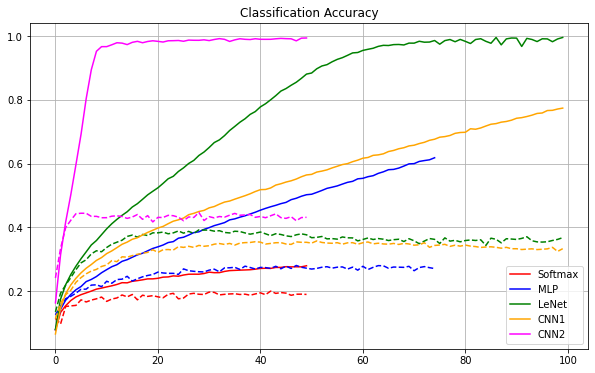

In [ ]:
summarize_all_diagnostics(m1, m2, m3, m4, m5)

Παρατηρώντας τις ακρίβειες των μοντέλων που δοκιμάσαμε, βλέπουμε ότι δεν ξεπερνούν το 45%. Προφανώς, η επιλογή μας να δουλέψουμε με τις 80 κλάσεις του συνόλου δεδομένων αύξησε την πολυπλοκότητα του προβλήματος μας. Πιο συγκεκριμένα, με λιγότερες κλάσεις αναμένουμε οι αποδόσεις των δικτύων μας να παρουσιάζουν καλύτερα αποτελέσματα.

Σχετικά με τους optimizers παρατηρήσαμε ότι η αποδόσεις τους εξαρτώνται από το ρυθμό μάθησης της εκπαίδευσης. Για παράδειγμα, είδαμε ότι οι Adam, Nadam, SGD και RMSProp παρουσιάζουν καλύτερα αποτελέσματα στα δίκτυά μας για ρυθμό μάθησης της τάξης του 0.0001, ενώ οι Adagrad και Adamax για ρυθμό μάθησης τάξης του 0.01. Όπως αναφέραμε και παραπάνω, δοκιμάσαμε τους περισσότερος από αυτούς για διάρκεια 10 εποχών και επιλέξαμε τους δύο καλύτερους, ανάλογα με τα αποτελέσματα που παρουσίασαν για τη μικρή αυτή διάρκεια εκπαίδευσης.

Τέλος, επιλέξαμε batch size μεγέθους 64 δειγμάτων, στηριζόμενοι σε [επιστημονικές δημοσιεύεσεις](https://www.sciencedirect.com/science/article/pii/S2405959519303455). Το μέγεθος του batch size είδαμε ότι σχετίζεται με το ρυθμό μάθησης της εκπαίδευσης. Το μέγεθος που επιλέξαμε είναι οικονομικό σε ότι αφορά τη μνήμη, ενώ είναι αρκετά μικρό για να μειώσουμε το φαινόμενο του overfitting στα δεδομένα εκπαίδευσης. Σημειώνουμε, τέλος, ότι με μεγαλύτερο batch size παρατηρήσαμε και μειωμένους χρόνους εκπαίδευσης. 

---

## Ερώτημα 2: Αντιμετώπιση Υπερεκπαίδευσης

Μελετώντας τα διάγραμματα των παραπάνω αρχιτεκτονικών παρατηρούμε μία έντονη διαφορά μεταξύ των καμπυλών ακρίβειας στα δεδομένα εκπαίδευσης και επαλήθευσης. Αυτή η διαφορά υποδεικνύει το πρόβλημα του overfitting στα δεδομένα εκπαίδευσης, το οποίο θα επιχειρήσουμε να αντιμετωπίσουμε με τις παρακάτω τρεις τεχνικές:

- Θα εφαμόσουμε την τεχνική του `tf.keras.callbacks.EarlyStopping`, κατά την οποία η εκπαίδευση θα διακόπτεται έαν δεν υφίσταται βελτίωση στη μείωση του σφάλματος για περισσότερο από n κύκλους εκπαίδευσης. Επιλέγουμε `patience=5`.

- Θα προσθέσουμε στις αρχιτεκτονικές των δικτύων μας `tf.keras.layers.Dropout` layers, οι οποίες θα αγνοούν τυχαία ένα ποσοστό των εισόδων τους. Ανάλογα με την αρχιτεκτονική των δικτύων μας, επιλέξαμε ποσοστά `0.10`, `0.25` και `0.50`.

- Τέλος, θα εκμεταλλευτούμε [ImageDataGenerator](https://bit.ly/33B1reJ), για να εφαρμόσουμε data augmentation στα δεδομένα εκπαίδευσης. Επιλέγουμε να χρησιμοποιήσουμε τους μετασχηματισμούς `rotation_range`, `width_shift_range`, `height_shift_range` και `horizontal_flip`.

**Στα παρακάτω δίκτυα θα συνδυάσουμε και τις 3 μεθόδους.**

Στα πλαίσια της άσκησης μας ζητείται να διατηρήσουμε τον καλύτερο συνδυασμό optimizer, loss, metric και epoch. Ενώ θα κρατήσουμε σταθερές τις πρώτες τρεις παραμέτρους, παρατηρήσαμε ότι τα μοντέλα μας παρουσιάζουν περιθώρια βελτίωσης και μετά τις 100 εποχές. Για να επιτύχουμε, λοιπόν, καλύτερα αποτελέσματα και δεδομένου ότι χρησιμοποιούμε τη μέθοδο του early stopping, θα επιλέξουμε για τα παρακάτω μοντέλα 200 `epochs`.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialization of EarlyStopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

### Softmax (Adagrad)

In [ ]:
def init_softmax_adagrad_opt(summary):
  
  model = models.Sequential()
  
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(200))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adagrad(lr=0.01), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
SOFTMAX_MODEL_ADAGRAD_OPT = init_softmax_adagrad_opt(summary=True)

# Data Augmentation
datagen = ImageDataGenerator(rotation_range=0.10, width_shift_range=0.10, height_shift_range=0.10, horizontal_flip=True)
it_train = datagen.flow(x_train, y_train, batch_size=64, shuffle=True)

steps = int(x_train.shape[0]/64)
SOFTMAX_MODEL_ADAGRAD_OPT_history = SOFTMAX_MODEL_ADAGRAD_OPT.fit(it_train, steps_per_epoch=steps, epochs=200, validation_data=(x_val, y_val), callbacks=[callback])

# Save model
SOFTMAX_MODEL_ADAGRAD_OPT.save('SOFTMAX_MODEL_ADAGRAD_OPT.h5')

# Dump training history
history_dict = SOFTMAX_MODEL_ADAGRAD_OPT_history.history
json.dump(history_dict, open('SOFTMAX_MODEL_ADAGRAD_OPT.json', 'w'))

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_28 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_60 (Dense)             (None, 200)               614600    
_________________________________________________________________
dense_61 (Dense)             (None, 100)               20100     
Total params: 634,700
Trainable params: 634,700
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
531/531 [==============================] - 22s 42ms/step - loss: 4.1353 - sparse_categorical_accuracy: 0.0673 - val_loss: 3.8161 - val_sparse_categorical_accuracy: 0.1177
Epoch 2/200
531/531 [==============================] - 22s 42ms/step - loss: 3.8377 - sparse_categorical_accuracy: 0.1073 - val_loss: 3.7225 - val_sparse_categorical_accuracy: 0.1355
Epoch 3/200

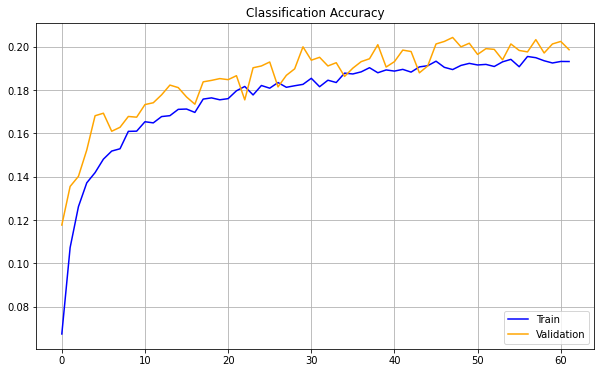


Test set evaluation metrics
125/125 [==============================] - 0s 4ms/step - loss: 3.4074 - sparse_categorical_accuracy: 0.2064
loss: 3.41
accuracy: 0.21


In [ ]:
model_report(SOFTMAX_MODEL_ADAGRAD_OPT, SOFTMAX_MODEL_ADAGRAD_OPT_history)

### MLP (Adagrad)

In [ ]:
def init_mlp_adagrad_opt(summary):
  
  model = models.Sequential()
 
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.25))
  model.add(layers.Dense(200))
  model.add(layers.Dropout(0.50))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adagrad(lr=0.01), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
MLP_MODEL_ADAGRAD_OPT = init_mlp_adagrad_opt(summary=True)

# Data Augmentation
datagen = ImageDataGenerator(rotation_range=0.10, width_shift_range=0.10, height_shift_range=0.10, horizontal_flip=True)
it_train = datagen.flow(x_train, y_train, batch_size=64, shuffle=True)

steps = int(x_train.shape[0]/64)
MLP_MODEL_ADAGRAD_OPT_history = MLP_MODEL_ADAGRAD_OPT.fit(it_train, steps_per_epoch=steps, epochs=200, validation_data=(x_val, y_val), callbacks=[callback])

# Save model
MLP_MODEL_ADAGRAD_OPT.save('MLP_MODEL_ADAGRAD_OPT.h5')

# Dump training history
history_dict = MLP_MODEL_ADAGRAD_OPT_history.history
json.dump(history_dict, open('MLP_MODEL_ADAGRAD_OPT.json', 'w'))

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_29 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_62 (Dense)             (None, 512)               1573376   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 200)               102600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 100)               20100     
Total params: 1,696,076
Trainable params: 1,696,076
Non-trainable params: 0
___________________________________________

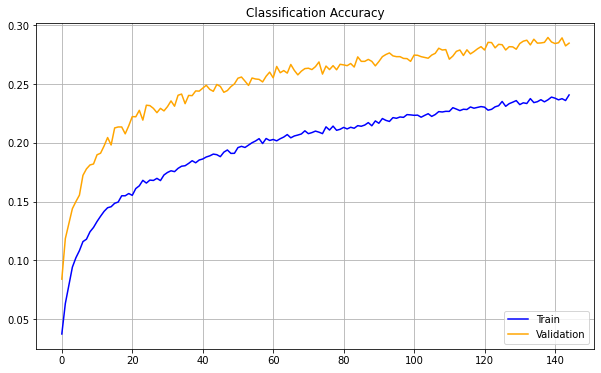


Test set evaluation metrics
125/125 [==============================] - 1s 4ms/step - loss: 2.9035 - sparse_categorical_accuracy: 0.2994
loss: 2.90
accuracy: 0.30


In [ ]:
model_report(MLP_MODEL_ADAGRAD_OPT, MLP_MODEL_ADAGRAD_OPT_history)

### LeNet (Adamax)

In [ ]:
def init_lenet_adam_opt(summary):
  
  model = models.Sequential()
 
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.25))
  model.add(layers.Dense(200))
  model.add(layers.Dropout(0.50))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adamax(lr=0.01), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
LENET_MODEL_ADAMAX_OPT = init_lenet_adam_opt(summary=True)

# Data Augmentation
datagen = ImageDataGenerator(rotation_range=0.10, width_shift_range=0.10, height_shift_range=0.10, horizontal_flip=True)
it_train = datagen.flow(x_train, y_train, batch_size=64, shuffle=True)

steps = int(x_train.shape[0]/64)
LENET_MODEL_ADAMAX_OPT_history = LENET_MODEL_ADAMAX_OPT.fit(it_train, steps_per_epoch=steps, epochs=200, validation_data=(x_val, y_val), callbacks=[callback])

# Save model
LENET_MODEL_ADAMAX_OPT.save('LENET_MODEL_ADAMAX_OPT.h5')

# Dump training history
history_dict = LENET_MODEL_ADAMAX_OPT_history.history
json.dump(history_dict, open('LENET_MODEL_ADAMAX_OPT.json', 'w'))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

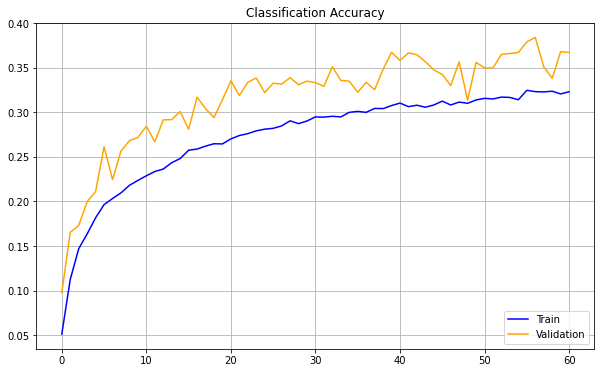


Test set evaluation metrics
125/125 [==============================] - 0s 3ms/step - loss: 2.5282 - sparse_categorical_accuracy: 0.3577
loss: 2.53
accuracy: 0.36


In [ ]:
model_report(LENET_MODEL_ADAM_OPT, LENET_MODEL_ADAM_OPT_history)

### CNN1 (Adam)

In [ ]:
def init_cnn1_adam_opt(summary):
  
  model = models.Sequential()
 
  model.add(layers.Conv2D(16, (5, 5), activation='relu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.Dropout(0.25))

  model.add(layers.Flatten())
  model.add(layers.Dense(200))
  model.add(layers.Dropout(0.50))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
CNN1_MODEL_ADAM_OPT = init_cnn1_adam_opt(summary=True)

# Data Augmentation
datagen = ImageDataGenerator(rotation_range=0.10, width_shift_range=0.10, height_shift_range=0.10, horizontal_flip=True)
it_train = datagen.flow(x_train, y_train, batch_size=64, shuffle=True)

steps = int(x_train.shape[0]/64)
CNN1_MODEL_ADAM_OPT_history = CNN1_MODEL_ADAM_OPT.fit(it_train, steps_per_epoch=steps, epochs=200, validation_data=(x_val, y_val), callbacks=[callback])

# Save model
CNN1_MODEL_ADAM_OPT.save('CNN1_MODEL_ADAM_OPT.h5')

# Dump training history
history_dict = CNN1_MODEL_ADAM_OPT_history.history
json.dump(history_dict, open('CNN1_MODEL_ADAM_OPT.json', 'w'))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 16)        1216      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 16)        2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 32)         

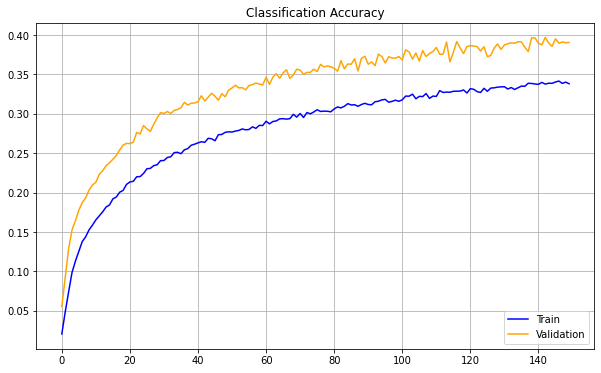


Test set evaluation metrics
125/125 [==============================] - 0s 3ms/step - loss: 2.3496 - sparse_categorical_accuracy: 0.3936
loss: 2.35
accuracy: 0.39


In [ ]:
model_report(CNN1_MODEL_ADAM_OPT, CNN1_MODEL_ADAM_OPT_history)

### CNN2 (Adam)

In [ ]:
def init_CNN2_adam_opt(summary):
  
  model = models.Sequential()
  
  model.add(layers.Conv2D(128, (3, 3), activation='elu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(128, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.10))
  model.add(layers.Conv2D(256, (3, 3), activation='elu', padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv2D(512, (3, 3), activation='elu', padding='same'))
  model.add(layers.Conv2D(512, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.50))
 
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='elu'))
  model.add(layers.Dropout(0.50))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
CNN2_MODEL_ADAM_OPT = init_CNN2_adam_opt(summary=True)

# Data Augmentation
datagen = ImageDataGenerator(rotation_range=0.10, width_shift_range=0.10, height_shift_range=0.10, horizontal_flip=True)
it_train = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

steps = int(x_train.shape[0]/BATCH_SIZE)
CNN2_MODEL_ADAM_OPT_history = CNN2_MODEL_ADAM_OPT.fit(it_train, steps_per_epoch=steps, epochs=200, validation_data=(x_val, y_val), callbacks=[callback])

# Save model
CNN2_MODEL_ADAM_OPT.save('CNN2_MODEL_ADAM_OPT.h5')

# Dump training history
history_dict = CNN2_MODEL_ADAM_OPT_history.history
json.dump(history_dict, open('CNN2_MODEL_ADAM_OPT.json', 'w'))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 256)         0

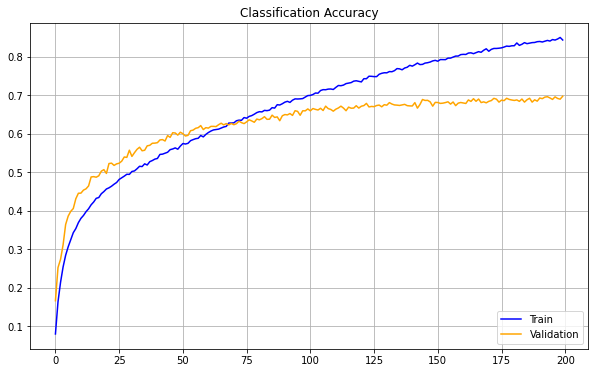


Test set evaluation metrics
125/125 [==============================] - 3s 22ms/step - loss: 1.2911 - sparse_categorical_accuracy: 0.7005
loss: 1.29
accuracy: 0.70


In [ ]:
model_report(CNN2_MODEL_ADAM_OPT, CNN2_MODEL_ADAM_OPT_history)

### Αξιολόγηση μοντέλων

Σύμφωνα με τα παραπάνω διαγράμματα, παρατηρούμε ότι επιλύσαμε επιτυχώς το πρόβλημα της υπερεκπαίδευσης των δικτύων μας, ενώ παράλληλα βελτιώσαμε και την ακρίβεια μερικών από αυτά, τόσο στα δεδομένα επαλήθευσης, όσο και στα δεδομένα ελέγχου. Στη συνέχεια παρουσιάζουμε ένα κοινό διάγραμμα με την ακρίβεια των εκάστοτε δικτύων πριν και μετά τη διαδικασία αντιμετώπισης του overfitting. **Με συνεχόμενη γραμμή αναπαριστούμε τα baseline μοντέλα, ενώ με διακεκομμένη τα βελτιστοποιημένα.**

In [23]:
# Reload best history according to accuracy-loss
m1 = json.load(open('SOFTMAX_MODEL_ADAGRAD.json', 'r'))
m2 = json.load(open('SOFTMAX_MODEL_ADAGRAD_OPT.json', 'r'))
m3 = json.load(open('MLP_MODEL_ADAGRAD.json', 'r'))
m4 = json.load(open('MLP_MODEL_ADAGRAD_OPT.json', 'r'))
m5 = json.load(open('LENET_MODEL_ADAMAX.json', 'r'))
m6 = json.load(open('LENET_MODEL_ADAMAX_OPT.json', 'r'))
m7 = json.load(open('CNN1_MODEL_ADAM.json', 'r'))
m8 = json.load(open('CNN1_MODEL_ADAM_OPT.json', 'r'))
m9 = json.load(open('CNN2_MODEL_ADAM.json', 'r'))
m10 = json.load(open('CNN2_MODEL_ADAM_OPT.json', 'r'))

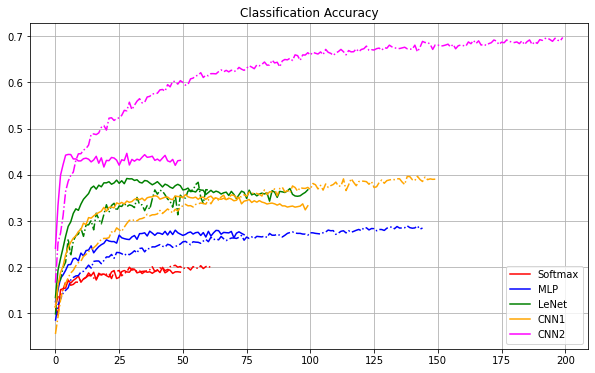

In [24]:
summarize_before_after(m1, m2, m3, m4, m5, m6, m7, m8, m9, m10)

---

## Ερώτημα 3: Transfer Learning

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

RESNET_MODEL = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in RESNET_MODEL.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

model = models.Sequential()
model.add(layers.UpSampling2D())
model.add(layers.UpSampling2D())
model.add(layers.UpSampling2D())
model.add(RESNET_MODEL)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.BatchNormalization())
model.add(layers.Dense(100, activation='softmax'))

model.compile(optimizer=tf.optimizers.Adam(lr=0.001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
datagen = ImageDataGenerator(rotation_range=0.10, width_shift_range=0.10, height_shift_range=0.10, horizontal_flip=True)
it_train = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

steps = int(x_train.shape[0]/BATCH_SIZE)
RESNET_MODEL_history = model.fit(it_train, steps_per_epoch=steps, epochs=10, validation_data=(x_val, y_val), callbacks=[callback])

Epoch 1/10
531/531 [==============================] - 655s 1s/step - loss: 2.2659 - sparse_categorical_accuracy: 0.4318 - val_loss: 6.5551 - val_sparse_categorical_accuracy: 0.0260
Epoch 2/10
531/531 [==============================] - 652s 1s/step - loss: 1.2906 - sparse_categorical_accuracy: 0.6373 - val_loss: 1.3739 - val_sparse_categorical_accuracy: 0.6108
Epoch 3/10
531/531 [==============================] - 653s 1s/step - loss: 1.0530 - sparse_categorical_accuracy: 0.6929 - val_loss: 0.9670 - val_sparse_categorical_accuracy: 0.7148
Epoch 4/10
531/531 [==============================] - 652s 1s/step - loss: 0.9151 - sparse_categorical_accuracy: 0.7298 - val_loss: 0.9161 - val_sparse_categorical_accuracy: 0.7325
Epoch 5/10
531/531 [==============================] - 652s 1s/step - loss: 0.8203 - sparse_categorical_accuracy: 0.7549 - val_loss: 0.8882 - val_sparse_categorical_accuracy: 0.7442
Epoch 6/10
531/531 [==============================] - 652s 1s/step - loss: 0.7570 - sparse_cate

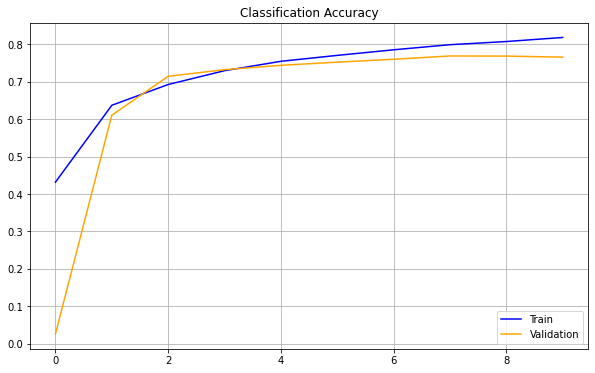


Test set evaluation metrics

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

125/125 [==============================] - 62s 496ms/step - loss: 0.7728 - sparse_categorical_accuracy: 0.7826
loss: 0.77
accuracy: 0.78


In [ ]:
# Save model
model.save('/content/drive/My Drive/ImageVideoAnalysis_ex2/trained_cnn/part3/RESNET_MODEL.h5')

# Dump training history
history_dict = RESNET_MODEL_history.history
json.dump(history_dict, open('/content/drive/My Drive/ImageVideoAnalysis_ex2/trained_cnn/part3/RESNET_MODEL.json', 'w'))

model_report(model, RESNET_MODEL_history)

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
RESNET_MODEL = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in RESNET_MODEL.layers:
  layer.trainable = False
  layer.training = False

model = models.Sequential()
model.add(layers.UpSampling2D())
model.add(layers.UpSampling2D())
model.add(layers.UpSampling2D())
model.add(RESNET_MODEL)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(100, activation='softmax'))

model.compile(optimizer=tf.optimizers.Adam(lr=0.001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
datagen = ImageDataGenerator(rotation_range=0.10, width_shift_range=0.10, height_shift_range=0.10, horizontal_flip=True)
it_train = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

steps = int(x_train.shape[0]/BATCH_SIZE)
RESNET_MODEL_history = model.fit(it_train, steps_per_epoch=steps, epochs=50, validation_data=(x_val, y_val), callbacks=[callback])

Epoch 1/50
531/531 [==============================] - 327s 616ms/step - loss: 4.1311 - sparse_categorical_accuracy: 0.0918 - val_loss: 3.8924 - val_sparse_categorical_accuracy: 0.0755
Epoch 2/50
531/531 [==============================] - 325s 612ms/step - loss: 3.5151 - sparse_categorical_accuracy: 0.1576 - val_loss: 3.2884 - val_sparse_categorical_accuracy: 0.2047
Epoch 3/50
531/531 [==============================] - 325s 612ms/step - loss: 3.2955 - sparse_categorical_accuracy: 0.1904 - val_loss: 3.0896 - val_sparse_categorical_accuracy: 0.2332
Epoch 4/50
531/531 [==============================] - 323s 609ms/step - loss: 3.1641 - sparse_categorical_accuracy: 0.2156 - val_loss: 3.1618 - val_sparse_categorical_accuracy: 0.2340
Epoch 5/50
531/531 [==============================] - 325s 613ms/step - loss: 3.0878 - sparse_categorical_accuracy: 0.2290 - val_loss: 3.0854 - val_sparse_categorical_accuracy: 0.2428
Epoch 6/50
531/531 [==============================] - 327s 616ms/step - loss: 3.

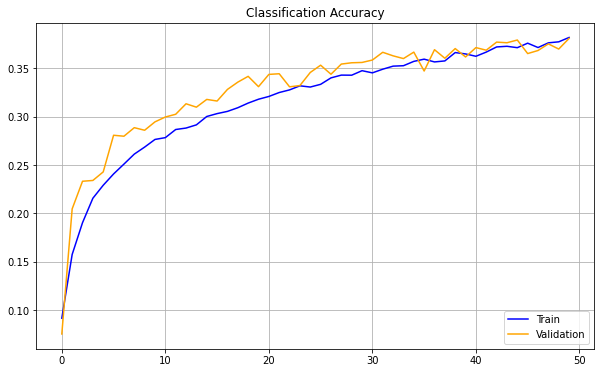


Test set evaluation metrics

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

125/125 [==============================] - 64s 508ms/step - loss: 2.4492 - sparse_categorical_accuracy: 0.3835
loss: 2.45
accuracy: 0.38


In [ ]:
# Save model
model.save('RESNET_MODEL2.h5')

# Dump training history
history_dict = RESNET_MODEL_history.history
json.dump(history_dict, open('RESNET_MODEL2.json', 'w'))

model_report(model, RESNET_MODEL_history)

In [ ]:
!wget "https://www.dropbox.com/s/s6owexvoo6acxk2/RESNET_MODEL2.h5?dl=1" "RESNET_MODEL2.h5"

--2020-07-23 20:40:41--  https://www.dropbox.com/s/s6owexvoo6acxk2/RESNET_MODEL2.h5?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.1, 2620:100:6023:1::a27d:4301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/s6owexvoo6acxk2/RESNET_MODEL2.h5 [following]
--2020-07-23 20:40:41--  https://www.dropbox.com/s/dl/s6owexvoo6acxk2/RESNET_MODEL2.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3514e933670000225ecd1e7fff.dl.dropboxusercontent.com/cd/0/get/A8HDLoGRRUjRlFn4cXSCrmwklCgBiLKJiwlOpvM0itVhGPERX2T2rpmb59i3GPP-u-cJmHpMiI_CSmO8vXiFiROQ-l2WayCiVChdtjkhqVi9EnubB5glN2llfOBdpE7iI_U/file?dl=1# [following]
--2020-07-23 20:40:41--  https://uc3514e933670000225ecd1e7fff.dl.dropboxusercontent.com/cd/0/get/A8HDLoGRRUjRlFn4cXSCrmwklCgBiLKJiwlOpvM0itVhGPERX2T2rpmb59i3GPP-u-cJmHpMiI_CSmO8vXiFiROQ-l2WayCiV

In [ ]:
model = tf.keras.models.load_model("RESNET_MODEL2.h5")

In [ ]:
for layer in model.layers:
  layer.trainable = True

model.compile(optimizer=tf.optimizers.Adam(lr=0.00001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
model_evaluation(model, 10)


Test set evaluation metrics
125/125 [==============================] - 66s 524ms/step - loss: 2.4492 - sparse_categorical_accuracy: 0.3835
loss: 2.45
accuracy: 0.38


In [ ]:
datagen = ImageDataGenerator(rotation_range=0.10, width_shift_range=0.10, height_shift_range=0.10, horizontal_flip=True)
it_train = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

steps = int(x_train.shape[0]/BATCH_SIZE)
RESNET_MODEL_history = model.fit(it_train, steps_per_epoch=steps, epochs=20, validation_data=(x_val, y_val), callbacks=[callback])

Epoch 1/20
531/531 [==============================] - 901s 2s/step - loss: 3.8350 - sparse_categorical_accuracy: 0.1573 - val_loss: 7.8680 - val_sparse_categorical_accuracy: 0.0127
Epoch 2/20
531/531 [==============================] - 898s 2s/step - loss: 2.4940 - sparse_categorical_accuracy: 0.3350 - val_loss: 2.6989 - val_sparse_categorical_accuracy: 0.2982
Epoch 3/20
531/531 [==============================] - 899s 2s/step - loss: 2.0807 - sparse_categorical_accuracy: 0.4240 - val_loss: 1.8482 - val_sparse_categorical_accuracy: 0.4788
Epoch 4/20
531/531 [==============================] - 899s 2s/step - loss: 1.8448 - sparse_categorical_accuracy: 0.4842 - val_loss: 1.6580 - val_sparse_categorical_accuracy: 0.5305
Epoch 5/20
531/531 [==============================] - 898s 2s/step - loss: 1.6669 - sparse_categorical_accuracy: 0.5357 - val_loss: 1.5257 - val_sparse_categorical_accuracy: 0.5727
Epoch 6/20
531/531 [==============================] - 898s 2s/step - loss: 1.5305 - sparse_cate

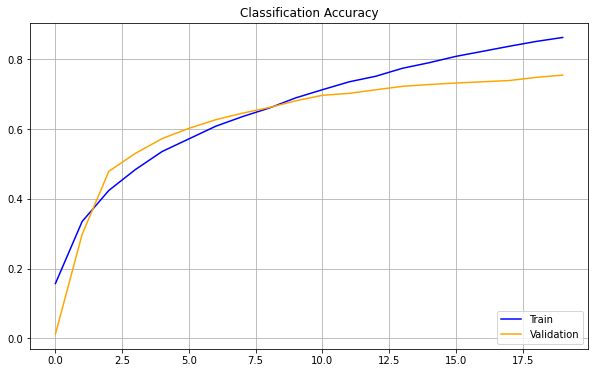


Test set evaluation metrics
125/125 [==============================] - 66s 526ms/step - loss: 0.8756 - sparse_categorical_accuracy: 0.7599
loss: 0.88
accuracy: 0.76


In [ ]:
# Save model
model.save('/content/drive/My Drive/ImageVideoAnalysis_ex2/trained_cnn/part3/RESNET_MODEL2_FINE.h5')

# Dump training history
history_dict = RESNET_MODEL_history.history
json.dump(history_dict, open('/content/drive/My Drive/ImageVideoAnalysis_ex2/trained_cnn/part3/RESNET_MODEL2_FINE.json', 'w'))

model_report(model, RESNET_MODEL_history)